In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
sns.set_context('notebook')
sns.set_style('darkgrid')

In [3]:
from scipy.io import loadmat
traindata = loadmat('data/ex4data1.mat')
print(traindata.keys())
# Let X and y be independent and dependent variable
X = traindata['X']
y = traindata['y']


print("Shape of X",X.shape)
print("Shape of y",y.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Shape of X (5000, 400)
Shape of y (5000, 1)


### Visualizing the Data

In [4]:
import matplotlib.image as mpimg
def PlotNumbers(X,Nrows=4):
    if Nrows > 100 :
        print("Too Large to Display")
        return
    nrow = int(np.sqrt(Nrows))
    ncol = int(np.sqrt(Nrows))
    m = X.shape[0] 
    fig,axis = plt.subplots(nrow,ncol,figsize=(5,5))
    for i in range(ncol):
        for j in range(ncol):
            axis[i,j].imshow(X[np.random.randint(0,m),:].reshape(20,20,order="F"))

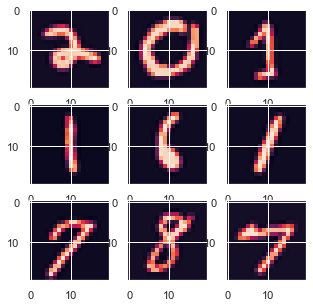

In [5]:
PlotNumbers(X,9)

### Model Representation

In [6]:
#Introduce Bias 
X = np.c_[np.ones(X.shape[0]),X]

#Loading Weights
datafile = 'data/ex4weights.mat'
mat = loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']

input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [7]:
print("Shape of Theta1",Theta1.shape)
print("Shape of Theta2",Theta2.shape)

Shape of Theta1 (25, 401)
Shape of Theta2 (10, 26)


### Preparing for Flattening and Reshaping

In [8]:
# 401x25 + 26x10 = 10285
def FlattenParams(theta1,theta2):
    return np.r_[theta1.ravel(),theta2.ravel()].reshape(((input_layer_size+1)*hidden_layer_size + \
        (hidden_layer_size+1)*output_layer_size),1)

# Theta1 25x401 and Theta2 10x26
def ReshapeParams(flattenedTheta):
    Theta1 = flattenedTheta[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = flattenedTheta[(hidden_layer_size*(input_layer_size+1)):].reshape(output_layer_size,hidden_layer_size+1)
    return [Theta1, Theta2]

### Random Initialization of Parameters


In [9]:
def Rand_InitializeTheta(lin,lout):
    epsil = (6/(lin+lout))**1/2
    W = np.random.rand(lin,lout+1) * (2*epsil) - epsil
    return W

In [10]:
def sigmoid(z):
    return 1/(1 + np.exp(-1*z))

def NNCostfunction(thetas,X,y,lamda=0):
    
    Theta1,Theta2 = ReshapeParams(thetas)
    
    m = X.shape[0]
    J = 0 
    y_matrix = pd.get_dummies(y.ravel())
    
    # Forward Propogation  OR Feed Forward
    a1 = X # 5000x401
    
    z2 = sigmoid(np.dot(X,Theta1.T)) # 5000x401 * 401x25 = 5000x25
    a2 = np.c_[np.ones(X.shape[0]),z2] # 5000x26
    
    z3 = np.dot(a2,Theta2.T) # 5000x10
    a3 = sigmoid(z3) # 5000x10
    
    epsilon = 1e-5    
    # If we use vectorized we do not need to sum explicitly
    J = (-1/m) * np.sum(np.sum(y_matrix * np.log(a3+epsilon) + (1 - y_matrix) * np.log(1-a3+epsilon)))
    #J = (-1/m) * np.sum(np.sum(np.log(a3)*y_matrix + np.log(1-a3)*(1 - y_matrix)))
    #J = (-1/m) * np.sum( np.dot(np.log(a3).T,y_matrix) +  np.dot(np.log(1-a3).T,(1-y_matrix)))
    J = J + (lamda/(2*m)) * (np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:])))
    
    return J

### BackPropogation 

In [11]:
def SigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

def Gradient(thetas,X,y,lamda=0):
    Theta1,Theta2 = ReshapeParams(thetas)
    
    m = X.shape[0]
    J = 0 
    y_matrix = pd.get_dummies(y.ravel())
    
    # Forward Propogation  OR Feed Forward
    a1 = X # 5000x401
    
    z2 = np.dot(X,Theta1.T) # 5000x401 * 401x25 = 5000x25
    a2 = np.c_[np.ones(X.shape[0]),sigmoid(z2)] # 5000x26
    
    z3 = np.dot(a2,Theta2.T) # 5000x10
    a3 = sigmoid(z3) # 5000x10
    
    ## Backpropogation 
    delta3 = a3 - np.array(y_matrix) #5000x10 
    delta2 = delta3.dot(Theta2[:,1:]) * SigmoidGradient(z2) # 5000x10 * 10x25 = 5000x25 
    delta1 = None # Since there can be no error with input layer 
    
    Delta2 = delta3.T.dot(a2) # 10x5000* 5000x26 = 10x26
    Delta1 = delta2.T.dot(a1) # 25x5000 * 5000x401 = 25x401
    
    # For Both Theta1 and Theta2 do not update the Theta0 i.e Theta associated with bias.
    # Since REgularization does not affect Theta0.
    
    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lamda / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lamda / m) * Theta2[:, 1:]
    
    return np.r_[Theta1_grad.ravel(),Theta2_grad.ravel()]


### Gradient Checking 

In [12]:
def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

def checkGradient(theta1,theta2,D1,D2,myX,myy,mylambda=0):
    myeps = 0.0001
    flattened = FlattenParams(theta1,theta2)
    flattenedDs = FlattenParams(D1,D2)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = NNCostfunction(flattened + epsvec,myX,myy,mylambda)
        cost_low  = NNCostfunction(flattened - epsvec,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [13]:
thetas = FlattenParams(Theta1,Theta2)
print(NNCostfunction(thetas,X,y))
grads = Gradient(thetas,X,y)
print("Shape of Gradient",grads.shape)
D1,D2 = ReshapeParams(grads)

0.28751238099868115
Shape of Gradient (10285,)


In [14]:
checkGradient(Theta1,Theta2,D1,D2,X,y)

Element: 4884. Numerical Gradient = -0.000041. BackProp Gradient = -0.000041.
Element: 8085. Numerical Gradient = -0.000026. BackProp Gradient = -0.000026.
Element: 8045. Numerical Gradient = 0.000001. BackProp Gradient = 0.000001.
Element: 4159. Numerical Gradient = -0.000356. BackProp Gradient = -0.000356.
Element: 2070. Numerical Gradient = 0.000005. BackProp Gradient = 0.000005.
Element: 7413. Numerical Gradient = 0.000250. BackProp Gradient = 0.000250.
Element: 6817. Numerical Gradient = 0.000112. BackProp Gradient = 0.000114.
Element: 10235. Numerical Gradient = -0.000561. BackProp Gradient = -0.000562.
Element: 5240. Numerical Gradient = 0.000003. BackProp Gradient = 0.000003.
Element: 9929. Numerical Gradient = -0.000171. BackProp Gradient = -0.000171.


## Prediction and Accuracy

In [15]:
def predictions(thetas,X):
    Theta1,Theta2 = ReshapeParams(thetas)
    m = X.shape[0]
    h1 = sigmoid(np.dot(X,Theta1.T))
    H1 = np.append(np.ones((m,1)),h1,axis=1)
    h2 = sigmoid(np.dot(H1,Theta2.T))
    pred = np.argmax(h2,axis=1)+1
    return pred

def accuracy(pred,y):
    pred.shape = (pred.size,1)
    return np.sum(pred == y)*100/float(y.shape[0])

In [16]:
pred = predictions(thetas,X)
print(NNCostfunction(thetas,X,y))
print("Accuracy : {} %".format(accuracy(pred,y)))

0.28751238099868115
Accuracy : 97.52 %


### Learning Theta Using Gradient Descent / Scipy / FminCG

In [17]:
from scipy.optimize import fmin_bfgs, fmin_cg
lamda = 0.01
maxIterations = 200
Learnttheta = fmin_cg(NNCostfunction,thetas,fprime = Gradient,
    args=(X,y,lamda), maxiter = maxIterations,disp = 1)
pred = predictions(Learnttheta,X)
print("Accuracy : {} %".format(accuracy(pred,y)))

Optimization terminated successfully.
         Current function value: 0.011421
         Iterations: 181
         Function evaluations: 652
         Gradient evaluations: 652
Accuracy : 100.0 %


In [18]:
print(NNCostfunction(Learnttheta,X,y))

0.002391784973557313


### Random Parameters

In [19]:
Theta1 = Rand_InitializeTheta(25,400)
Theta2 = Rand_InitializeTheta(10,25)
Theta1.shape,Theta2.shape

((25, 401), (10, 26))

In [20]:
thetas = FlattenParams(Theta1,Theta2)
print("Loss : ",NNCostfunction(thetas,X,y))
pred = predictions(thetas,X)
print("Accuracy : {} %".format(accuracy(pred,y)))

Loss :  6.907571098802985
Accuracy : 10.0 %


In [21]:
lamda = 0.09
maxIterations = 100
Learnttheta = fmin_cg(NNCostfunction,thetas,fprime = Gradient,
    args=(X,y,lamda), maxiter = maxIterations,disp = 1)
print("Loss : ",NNCostfunction(Learnttheta,X,y))
pred = predictions(Learnttheta,X)
print("Accuracy : {} %".format(accuracy(pred,y)))

         Current function value: 0.140832
         Iterations: 100
         Function evaluations: 237
         Gradient evaluations: 237
Loss :  0.11346050888543582
Accuracy : 99.26 %


### Trying Our Own Image 

In [22]:
import cv2
import PIL
from PIL import Image

In [23]:
basewidth = 20
img = Image.open('number4.jpeg')
wpercent = (basewidth / float(img.size[0]))
#hsize = int((float(img.size[1]) * float(wpercent)))
hsize=basewidth
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save('number_resized.jpg')

In [24]:
img = cv2.imread('number_resized.jpg', 0) 
img.shape

(20, 20)

In [25]:
img = img.ravel()

In [26]:
img.shape

(400,)

#### I have written 5 in a very confusing way 

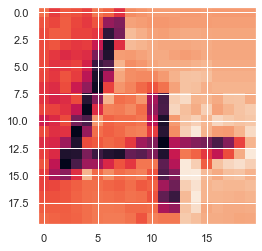

In [27]:
plt.imshow(img.reshape(20,20,order="A"))

In [28]:
img = img.reshape(1,400)

In [29]:
img.shape

(1, 400)

In [30]:
img = np.c_[1,img]

In [31]:
img.shape

(1, 401)

In [36]:
pred = predictions(Learnttheta,img)
print(pred)

[4]
